<a href="https://colab.research.google.com/github/DarthCipher7/DR/blob/main/DR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
#cell 1

from google.colab import drive
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Drive mounted successfully.")

Mounting Google Drive...
Mounted at /content/drive
Drive mounted successfully.


In [21]:
#cell 2

import os
import zipfile

# --- Paths Configuration ---
# IMPORTANT: Make sure this path to your zip file is correct!
zip_path = '/content/drive/MyDrive/Colab Notebooks/data.zip'

# Path to extract data to in the Colab environment
extract_path = '/content/data'
image_folder_path = os.path.join(extract_path, 'gaussian_filtered_images') # The folder with class subdirectories

# --- Unzipping Logic ---
if os.path.exists(image_folder_path):
    print(f"✅ Dataset already exists in '{extract_path}'. Skipping unzipping.")
else:
    print(f"🗂️ Dataset not found. Starting extraction from Google Drive...")
    print(f"   Source: {zip_path}")
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("✅ Data unzipped successfully!")
    except FileNotFoundError:
        print("❌ ERROR: The zip file was not found at the specified path.")
        print("   Please double-check the 'zip_path' variable in this cell.")
    except Exception as e:
        print(f"❌ An error occurred during unzipping: {e}")


# --- Verification ---
if os.path.exists(image_folder_path):
    print("\n--- Dataset Contents ---")
    # Using !ls for a clean, readable output in Colab
    !ls -l {image_folder_path}

🗂️ Dataset not found. Starting extraction from Google Drive...
   Source: /content/drive/MyDrive/Colab Notebooks/data.zip
✅ Data unzipped successfully!


In [26]:
#cell 3

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import os

# --- Parameters ---
DATA_DIR = '/content/data/data/gaussian_filtered_images/gaussian_filtered_images'
# Switched to 224x224 to match the dataset and EfficientNetB0
IMG_SIZE = (224, 224)
# Increased batch size for more stable gradients
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2

# --- Create Data Generators with Augmentation ---
# This creates variations of our images during training to prevent overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True, # Often useful in retinal images
    fill_mode='nearest',
    validation_split=VALIDATION_SPLIT
)

# For validation, we only rescale the images. No augmentation.
validation_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)

# --- Flow Data from Directory ---
print("Loading training data...")
train_generator = train_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

print("\nLoading validation data...")
validation_generator = validation_datagen.flow_from_directory(
    directory=DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False # Important: Do not shuffle validation data
)

# --- Calculate Class Weights to Handle Imbalance ---
# This tells the model to pay more attention to the minority classes
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

print(f"\n✅ Data generators created.")
print(f"   Training on {train_generator.n} images.")
print(f"   Validating on {validation_generator.n} images.")
print(f"\nClass Indices: {train_generator.class_indices}")
print(f"Calculated Class Weights: \n{class_weights_dict}")

Loading training data...
Found 2931 images belonging to 5 classes.

Loading validation data...
Found 731 images belonging to 5 classes.

✅ Data generators created.
   Training on 2931 images.
   Validating on 731 images.

Class Indices: {'Mild': 0, 'Moderate': 1, 'No_DR': 2, 'Proliferate_DR': 3, 'Severe': 4}
Calculated Class Weights: 
{0: np.float64(1.9804054054054054), 1: np.float64(0.73275), 2: np.float64(0.4059556786703601), 3: np.float64(2.483898305084746), 4: np.float64(3.7819354838709676)}


In [27]:
# Run this in a new cell to check your data structure
import os

DATA_DIR = '/content/data/data/gaussian_filtered_images/gaussian_filtered_images'
print("Class directories found:")
class_dirs = [d for d in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, d))]
print(class_dirs)

print("\nNumber of images per class:")
for class_name in class_dirs:
    print(f"- {class_name}: {len(os.listdir(os.path.join(DATA_DIR, class_name)))} images")

Class directories found:
['Mild', 'Severe', 'Proliferate_DR', 'No_DR', 'Moderate']

Number of images per class:
- Mild: 370 images
- Severe: 193 images
- Proliferate_DR: 295 images
- No_DR: 1805 images
- Moderate: 999 images


In [28]:
# In Cell 4

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# --- Path to Save the Best Model in Google Drive ---
# IMPORTANT: Create this folder in your Google Drive beforehand
model_save_dir = '/content/drive/MyDrive/Diabetic_Retinopathy_Project/saved_models'
os.makedirs(model_save_dir, exist_ok=True)
model_save_path = os.path.join(model_save_dir, 'best_dr_model_efficientnetb0.keras')


def build_model(num_classes):
    """
    Builds the EfficientNetB0 model for transfer learning.
    """
    # Load EfficientNetB0 with pre-trained ImageNet weights, excluding the top classification layer
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

    # Freeze the base model layers initially
    base_model.trainable = False

    # Add our custom classifier on top
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dropout(0.4)(x) # Regularization to prevent overfitting
    outputs = Dense(num_classes, activation='softmax', name='predictions')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# --- Build the Model ---
num_classes = train_generator.num_classes
model = build_model(num_classes=num_classes)

# --- Compile the Model for Stage 1 ---
# Using a higher learning rate for the newly initialized head
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model built and compiled for initial training.")
model.summary()


# --- Define Callbacks ---
# Save the best model directly to Google Drive
checkpoint = ModelCheckpoint(
    filepath=model_save_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1,
    mode='min'
)

# Stop training if the validation loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5, # More patience
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# Reduce the learning rate when performance plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce LR by a factor of 5
    patience=2,
    verbose=1,
    mode='min'
)

print(f"\n✅ Callbacks defined. Best model will be saved to: {model_save_path}")

✅ Model built and compiled for initial training.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


✅ Callbacks defined. Best model will be saved to: /content/drive/MyDrive/Diabetic_Retinopathy_Project/saved_models/best_dr_model_efficientnetb0.keras


In [29]:
# In Cell 5

EPOCHS_STAGE_1 = 25 # Train for up to 25 epochs

print("--- Starting Stage 1: Training the Classifier Head ---")

history_head = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE_1,
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\n✅ Stage 1 Training Complete.")

--- Starting Stage 1: Training the Classifier Head ---


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 517ms/step - accuracy: 0.2028 - loss: 1.6228

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 1.55780, saving model to /content/drive/MyDrive/Diabetic_Retinopathy_Project/saved_models/best_dr_model_efficientnetb0.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 663ms/step - accuracy: 0.2027 - loss: 1.6230 - val_accuracy: 0.4938 - val_loss: 1.5578 - learning_rate: 0.0010
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.2270 - loss: 1.6221
Epoch 2: val_loss did not improve from 1.55780
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 456ms/step - accuracy: 0.2267 - loss: 1.6222 - val_accuracy: 0.0520 - val_loss: 1.7159 - learning_rate: 0.0010
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.1847 - loss: 1.6161
Epoch 3: val_loss did not improve from 1.55780

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 467ms/step - accuracy: 0.1848 - loss: 1.6164 - val_accuracy: 0.0520 - val_loss: 1.7481 - learning_rate: 0.0010
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step - accuracy: 0

In [30]:
#cell 6

# --- Prepare for Fine-Tuning ---
# We must re-load the best model weights saved from Stage 1
# This is because EarlyStopping might have restored older weights
print("Loading best model from Stage 1 for fine-tuning...")
model.load_weights(model_save_path)

# Access the actual base model (EfficientNetB0) which is within the functional model.
# We need to find the layer that is the EfficientNetB0 model.
efficientnet_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and layer.name.startswith('efficientnet'):
        efficientnet_layer = layer
        break

if efficientnet_layer is not None:
    print(f"Found EfficientNet layer: {efficientnet_layer.name}")
    efficientnet_layer.trainable = True

    # Unfreeze the top 30 layers of the EfficientNet model.
    # We keep the early layers (which detect basic shapes/edges) frozen.
    for layer in efficientnet_layer.layers[:-30]:
        layer.trainable = False
else:
    print("Error: Could not find the EfficientNet layer in the model.")


# --- Re-compile the Model for Fine-Tuning ---
# It is ESSENTIAL to use a very low learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5), # <--- VERY LOW LR
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n✅ Model re-compiled for fine-tuning.")
model.summary() # Note the change in trainable parameters


# --- Continue Training (Fine-Tuning) ---
EPOCHS_STAGE_2 = 50 # Give it plenty of time to fine-tune

print("\n--- Starting Stage 2: Fine-Tuning Top Layers ---")

# We continue training from where we left off
history_fine_tune = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE_2, # Total epochs for the entire process
    # The callbacks will continue to work, saving the best fine-tuned model
    # and stopping early if needed.
    validation_data=validation_generator,
    class_weight=class_weights_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print("\n✅ Stage 2 Fine-Tuning Complete.")

Loading best model from Stage 1 for fine-tuning...
Error: Could not find the EfficientNet layer in the model.

✅ Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- Starting Stage 2: Fine-Tuning Top Layers ---
Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.2822 - loss: 1.6050
Epoch 1: val_loss did not improve from 1.55780
92/92 ━━━━━━━━━━━━━━━━━━━━ 80s 642ms/step - accuracy: 0.2821 - loss: 1.6052 - val_accuracy: 0.4938 - val_loss: 1.5717 - learning_rate: 1.0000e-05
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2491 - loss: 1.6156
Epoch 2: val_loss did not improve from 1.55780
92/92 ━━━━━━━━━━━━━━━━━━━━ 57s 468ms/step - accuracy: 0.2491 - loss: 1.6158 - val_accuracy: 0.4938 - val_loss: 1.5842 - learning_rate: 1.0000e-05
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.2643 - loss: 1.5939
Epoch 3: val_loss did not improve from 1.55780

Epoch 3: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 454ms/step - accuracy: 0.2640 - loss: 1.5944 - val_accuracy: 0.4938 - val_loss: 1.5952 - learning_rate: 1.0000e-05
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━

Loading final best model from Google Drive for evaluation...
✅ Model loaded successfully.
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 240ms/step - accuracy: 0.2717 - loss: 1.6424

--- Final Model Evaluation on Validation Data ---
Loss: 1.5578
Accuracy: 49.38%

Generating predictions for classification report and confusion matrix...


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 329ms/step

--- Final Accuracy Score: 49.38% ---

--- Classification Report ---
                precision    recall  f1-score   support

          Mild       0.00      0.00      0.00        74
      Moderate       0.00      0.00      0.00       199
         No_DR       0.49      1.00      0.66       361
Proliferate_DR       0.00      0.00      0.00        59
        Severe       0.00      0.00      0.00        38

      accuracy                           0.49       731
     macro avg       0.10      0.20      0.13       731
  weighted avg       0.24      0.49      0.33       731


--- Confusion Matrix ---


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


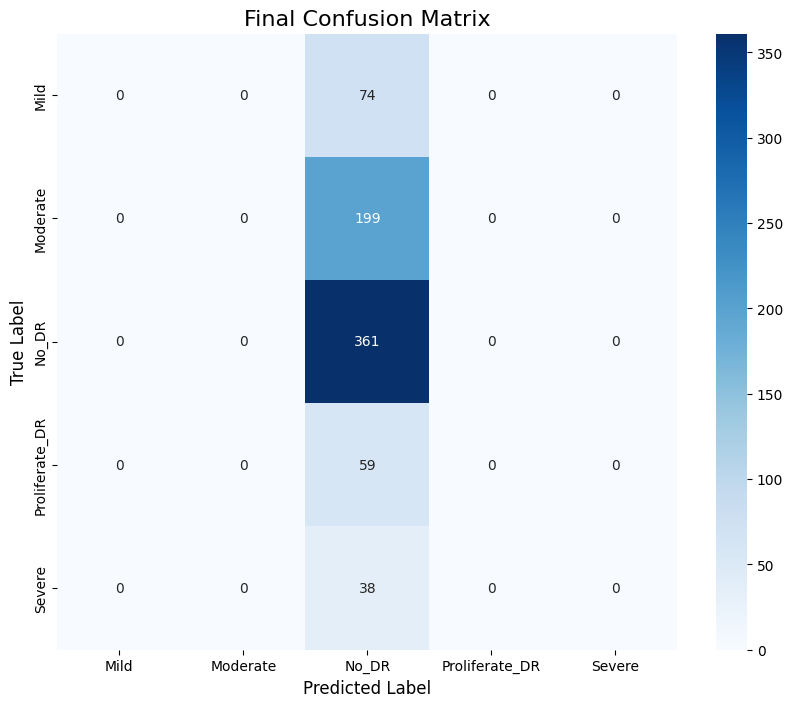

In [31]:
#cell 7

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- Load the BEST saved model from Google Drive for final evaluation ---
print("Loading final best model from Google Drive for evaluation...")
final_model = tf.keras.models.load_model(model_save_path)
print("✅ Model loaded successfully.")

# --- Evaluate the model ---
loss, accuracy = final_model.evaluate(validation_generator)
print(f"\n--- Final Model Evaluation on Validation Data ---")
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")


# --- Generate Predictions for Detailed Metrics ---
print("\nGenerating predictions for classification report and confusion matrix...")
# Reset the generator to be safe
validation_generator.reset()
predictions = final_model.predict(validation_generator, steps=int(np.ceil(validation_generator.n / BATCH_SIZE))) # Convert to integer
y_pred = np.argmax(predictions, axis=1)
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# --- Display Results ---
print(f"\n--- Final Accuracy Score: {accuracy_score(y_true, y_pred) * 100:.2f}% ---\n")
print("--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=class_labels))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Final Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

Please upload a retinal image for prediction:


Saving 0f882877bf13.png to 0f882877bf13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


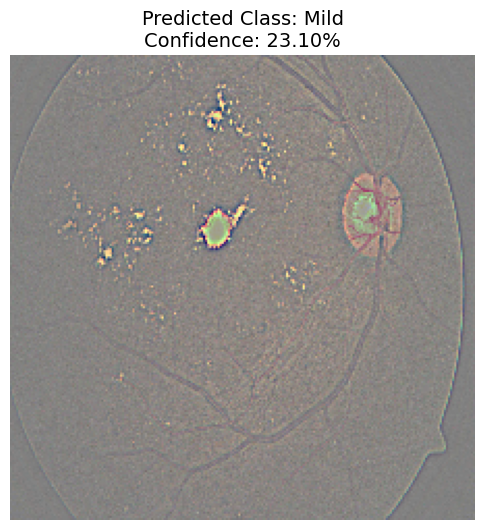

In [20]:
#Cell 8

import numpy as np
from google.colab import files
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# --- Load the saved model from Drive ---
predictor_model = tf.keras.models.load_model(model_save_path)

# --- Get class names from the generator ---
class_indices = train_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

# --- Upload file ---
print("Please upload a retinal image for prediction:")
uploaded = files.upload()

# --- Process and predict each uploaded file ---
for fn in uploaded.keys():
  # Load and prepare the image
  path = '/content/' + fn
  img = load_img(path, target_size=IMG_SIZE)
  img_array = img_to_array(img)
  img_array /= 255.0
  img_batch = np.expand_dims(img_array, axis=0)

  # Make prediction
  prediction = predictor_model.predict(img_batch)
  predicted_class_index = np.argmax(prediction[0])
  predicted_class_label = class_labels[predicted_class_index]
  confidence = np.max(prediction[0]) * 100

  # Display results
  plt.figure(figsize=(6, 7))
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"Predicted Class: {predicted_class_label}\nConfidence: {confidence:.2f}%", fontsize=14)
  plt.show()